In [197]:
import pandas as pd
import geopandas
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [198]:
###put the taxi data into dataframe
df08 = pq.read_table('../Downloads/yellow_tripdata_2020-08.parquet').to_pandas()
df09 = pq.read_table('../Downloads/yellow_tripdata_2020-09.parquet').to_pandas()
df07 = pq.read_table('../Downloads/yellow_tripdata_2020-07.parquet').to_pandas()



In [233]:

###combine three dataframe into one df
temp78df=pd.concat([df07,df08], axis=0)
all7_9df = pd.concat([temp78df,df09], axis=0)
all7_9df.index = range(len(all7_9df))
all7_9df.shape



(3148715, 19)

In [242]:
###data cleaning
##remove the null item
sub_df = all7_9df.iloc[:,[1,2,3,4,7,8,9,10,13,16]].dropna()
sub_df.to_parquet('../ads/subdf.parquet',compression='gzip')
sub_df.tail(10)
sub_df2 = pd.read_parquet('../ads/subdf.parquet')
sub_df2.shape

(2924448, 10)

In [241]:
sub_df.shape
sub_df[['fare_amount', 'tip_amount']].describe()

,fare_amount,tip_amount
count,2.924448e+06,2.924448e+06
mean,1.153852e+01,1.834569e+00
std,1.101150e+02,2.495186e+00
min,-4.800000e+02,-1.110000e+02
25%,6.000000e+00,0.000000e+00
50%,8.500000e+00,1.700000e+00
75%,1.300000e+01,2.660000e+00
max,1.874390e+05,1.001000e+03


In [254]:
##remove the outlier
sub_df2 = sub_df2[sub_df2.trip_distance > 0]
sub_df2 = sub_df2[sub_df2.fare_amount >=2.5]
sub_df2=sub_df2[sub_df2.tip_amount>=0]
sub_df2=sub_df2[sub_df2.tip_amount>=0]
sub_df2=sub_df2[sub_df2.fare_amount<400]
sub_df2=sub_df2[sub_df2.payment_type != 3]
sub_df2=sub_df2[sub_df2.payment_type != 4]
sub_df2 = sub_df2[(sub_df2.trip_distance < 200) & (sub_df2.fare_amount < 1000)  & (sub_df2.tip_amount < 500) ]
print(sub_df2.shape)
print(sub_df.PULocationID.min())
print(sub_df.PULocationID.max())
print(sub_df.DOLocationID.min())
print(sub_df.DOLocationID.max())

(2819417, 10)
1
265
1
265


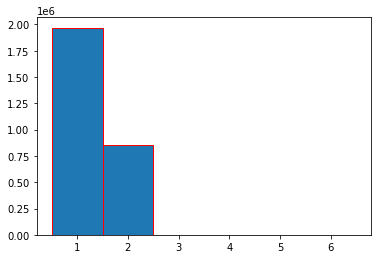

In [255]:
# payment_type 
fig, ax = plt.subplots()
ax.hist(sub_df2.payment_type, bins=6, range=(1, 7), align='left', edgecolor="red")
plt.show()

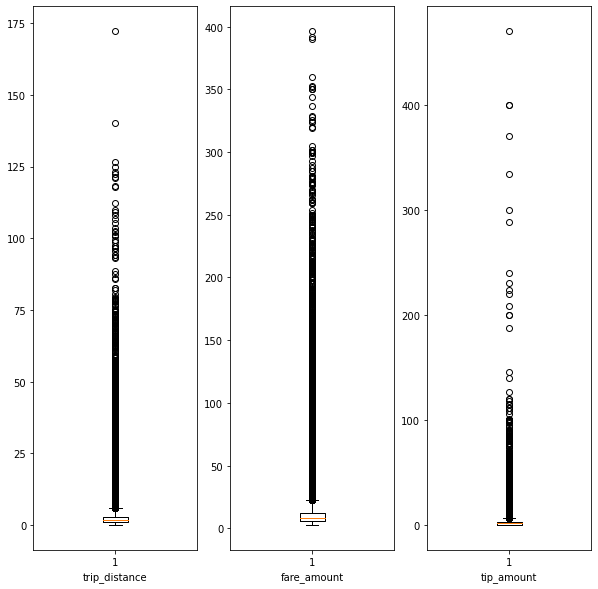

In [256]:
cols = ['trip_distance', 'fare_amount', 'tip_amount']
fig, axs = plt.subplots(1, 3, figsize=(10,10))
axs[0].boxplot(sub_df2[cols[0]])
axs[0].set_xlabel(cols[0])
axs[1].boxplot(sub_df2[cols[1]])
axs[1].set_xlabel(cols[1])
axs[2].boxplot(sub_df2[cols[2]])
axs[2].set_xlabel(cols[2])
plt.show()

In [257]:
Q0 = sub_df2[cols].quantile(0.05)
Q1 = sub_df2[cols].quantile(0.25)
Q3 = sub_df2[cols].quantile(0.75)
Q4 = sub_df2[cols].quantile(0.95)
IQR = Q3 - Q1
print("Q0: ", Q0)
print("Q1: ", Q1)
print("Q3: ", Q3)
print("Q4: ", Q4)
print("IQR: ", IQR)


Q0:  trip_distance    0.5
fare_amount      4.0
tip_amount       0.0
Name: 0.05, dtype: float64
Q1:  trip_distance    1.01
fare_amount      6.00
tip_amount       0.00
Name: 0.25, dtype: float64
Q3:  trip_distance     2.97
fare_amount      12.50
tip_amount        2.75
Name: 0.75, dtype: float64
Q4:  trip_distance     8.60
fare_amount      28.50
tip_amount        5.06
Name: 0.95, dtype: float64
IQR:  trip_distance    1.96
fare_amount      6.50
tip_amount       2.75
dtype: float64


In [262]:
removed_df = sub_df2[~((sub_df2[cols] < (Q1 - 1.5 * IQR)) | (sub_df2[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
removed_df.shape

(2538745, 10)

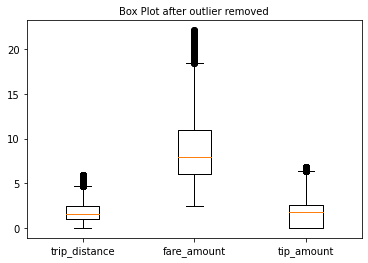

In [263]:
# show the tips after remove outliers
fig, ax = plt.subplots()
ax.boxplot(removed_df[cols])
ax.set_xticklabels(cols, fontsize=10)
plt.title('Box Plot after outlier removed',fontsize=10)
# fig.savefig("Box Plot after outlier removed.png")
plt.show()

In [264]:
removed_df['minutes'] = (removed_df.tpep_dropoff_datetime - removed_df.tpep_pickup_datetime).to_numpy().astype('timedelta64[s]').astype(int)/60
feature_df = removed_df
print(removed_df.shape)
##remove the trip that was too long
feature_df = feature_df[feature_df['minutes'] < 120]
feature_df.shape


/var/folders/42/f_6v078j0xd9603097bqpqcc0000gn/T/ipykernel_10588/1218011229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  removed_df['minutes'] = (removed_df.tpep_dropoff_datetime - removed_df.tpep_pickup_datetime).to_numpy().astype('timedelta64[s]').astype(int)/60


(2538745, 11)


(2534056, 11)

In [265]:
tip_df = feature_df.loc[feature_df['payment_type'] == 1, ['fare_amount', 'tip_amount']]
tip_rate = (tip_df.tip_amount/tip_df.fare_amount).mean()
print(tip_rate)
tip_df[tip_df.fare_amount ==0]

0.2725228895772397


,fare_amount,tip_amount


In [266]:
#feature_df.shape
#feature_df[feature_df.index.duplicated()]

#feature_df = feature_df[~feature_df.index.duplicated()]
feature_df.loc[feature_df['payment_type'] == 2, 'tip_amount'] = feature_df['fare_amount'] * tip_rate
feature_df.head(10)




/Users/linfeiyu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,minutes
0,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,238,75,2,8.0,2.180183,9.30,8.116667
2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,230,88,2,18.5,5.041673,22.30,14.216667
3,2020-07-01 00:30:49,2020-07-01 00:38:26,1.0,1.90,88,232,1,8.0,2.360000,14.16,7.616667
4,2020-07-01 00:31:26,2020-07-01 00:38:02,1.0,1.25,37,17,2,6.5,1.771399,7.80,6.600000
6,2020-07-01 00:44:08,2020-07-01 00:58:12,1.0,5.27,137,260,1,16.5,6.090000,26.39,14.066667
7,2020-07-01 00:49:20,2020-07-01 00:56:44,1.0,1.32,166,41,2,7.5,2.043922,8.80,7.400000
8,2020-07-01 00:21:59,2020-07-01 00:25:12,1.0,0.73,239,142,1,5.0,1.320000,10.12,3.216667
11,2020-07-01 00:40:49,2020-07-01 00:51:59,3.0,4.97,79,195,2,16.0,4.360366,19.80,11.166667
13,2020-07-01 00:08:53,2020-07-01 00:12:42,1.0,0.57,263,263,2,4.5,1.226353,8.30,3.816667
16,2020-07-01 00:16:31,2020-07-01 00:16:43,1.0,2.80,141,141,2,2.5,0.681307,5.80,0.200000


In [267]:
##calculate the incomerate of the taxidriver
feature_df['income_rate'] = (feature_df['fare_amount'] + feature_df['tip_amount'])/feature_df['minutes']
feature_df.head()

/var/folders/42/f_6v078j0xd9603097bqpqcc0000gn/T/ipykernel_10588/649611784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['income_rate'] = (feature_df['fare_amount'] + feature_df['tip_amount'])/feature_df['minutes']


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,minutes,income_rate
0,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,238,75,2,8.0,2.180183,9.30,8.116667,1.254232
2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,230,88,2,18.5,5.041673,22.30,14.216667,1.655921
3,2020-07-01 00:30:49,2020-07-01 00:38:26,1.0,1.90,88,232,1,8.0,2.360000,14.16,7.616667,1.360175
4,2020-07-01 00:31:26,2020-07-01 00:38:02,1.0,1.25,37,17,2,6.5,1.771399,7.80,6.600000,1.253242
6,2020-07-01 00:44:08,2020-07-01 00:58:12,1.0,5.27,137,260,1,16.5,6.090000,26.39,14.066667,1.605924


In [271]:
feature_df['hour_of_day'] = feature_df.tpep_pickup_datetime.dt.hour
feature_df['day_of_week'] = feature_df.tpep_pickup_datetime.dt.day_of_week
feature_df

/var/folders/42/f_6v078j0xd9603097bqpqcc0000gn/T/ipykernel_10588/357798353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['hour_of_day'] = feature_df.tpep_pickup_datetime.dt.hour
/var/folders/42/f_6v078j0xd9603097bqpqcc0000gn/T/ipykernel_10588/357798353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['day_of_week'] = feature_df.tpep_pickup_datetime.dt.day_of_week


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,total_amount,minutes,income_rate,hour_of_day,day_of_week
0,2020-07-01 00:25:32,2020-07-01 00:33:39,1.0,1.50,238,75,2,8.0,2.180183,9.30,8.116667,1.254232,0,2
2,2020-07-01 00:15:11,2020-07-01 00:29:24,1.0,5.85,230,88,2,18.5,5.041673,22.30,14.216667,1.655921,0,2
3,2020-07-01 00:30:49,2020-07-01 00:38:26,1.0,1.90,88,232,1,8.0,2.360000,14.16,7.616667,1.360175,0,2
4,2020-07-01 00:31:26,2020-07-01 00:38:02,1.0,1.25,37,17,2,6.5,1.771399,7.80,6.600000,1.253242,0,2
6,2020-07-01 00:44:08,2020-07-01 00:58:12,1.0,5.27,137,260,1,16.5,6.090000,26.39,14.066667,1.605924,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058529,2020-09-30 23:41:37,2020-09-30 23:56:14,1.0,4.14,142,146,1,15.0,3.760000,22.56,14.616667,1.283466,23,2
3058530,2020-09-30 23:04:18,2020-09-30 23:14:25,1.0,4.30,75,226,2,13.5,3.679059,17.30,10.116667,1.698095,23,2
3058531,2020-09-30 23:43:18,2020-09-30 23:52:38,1.0,2.20,234,229,1,9.0,2.550000,15.35,9.333333,1.237500,23,2
3058532,2020-09-30 23:19:35,2020-09-30 23:23:58,1.0,1.14,75,238,1,6.0,2.000000,9.30,4.383333,1.825095,23,2


In [272]:
dw_mapping={
    0: 'MON', 
    1: 'TUE', 
    2: 'WEDN', 
    3: 'THUR', 
    4: 'FRI',
    5: 'SAT', 
    6: 'SUN'
} 
feature_df.tpep_pickup_datetime.dt.day_of_week.map(dw_mapping)

0          WEDN
2          WEDN
3          WEDN
4          WEDN
6          WEDN
           ... 
3058529    WEDN
3058530    WEDN
3058531    WEDN
3058532    WEDN
3058533    WEDN
Name: tpep_pickup_datetime, Length: 2534056, dtype: object

In [274]:
feature_df[['minutes', 'income_rate']].describe()

,minutes,income_rate
count,2.534056e+06,2.534056e+06
mean,9.582237e+00,inf
std,1.202711e+01,NaN
min,-1.694960e+04,-1.990497e-02
25%,5.400000e+00,1.058501e+00
50%,8.466667e+00,1.228426e+00
75%,1.266667e+01,1.478873e+00
max,1.179000e+02,inf
